# Modeling Crop Yield

In [1]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

## Parameters

In [2]:
# satellite = "landsat-8-c2-l2"
satellite = "sentinel-2"
country_code = "ZMB"
points = "15"
num_features = "1000"
feature_file_name = (f'{satellite}_{country_code}_{points}'
                     f'k-points_{num_features}-features')

weight_file_name = (f'{country_code}_crop_weights{points}k-points')

## Boundaries 

In [3]:
country_shp = geopandas.read_file(f'/capstone/cropmosaiks/data/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
# country_shp.plot(column = 'district',linewidth = 1, edgecolor = 'black' )
# country_shp

(72, 1)

## Crops

In [4]:
crop_df = pd.read_csv('/capstone/cropmosaiks/data/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
crop_df = crop_df.set_index('district')
# crop_df

In [5]:
list(set(crop_districts) - set(country_districts))

['Mafinga', 'Ikelenge']

In [6]:
list(set(country_districts) - set(crop_districts))

[]

In [7]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Weights

In [8]:
# weights = pd.read_feather(f"data/weights/{weight_file_name}_2018.feather")
# weights.crop_perc = weights.crop_perc.fillna(0)
# weights.crop_perc = weights.crop_perc + 0.0001
# weights

In [9]:
# weights_gdf.plot(figsize = (15,15),
                 # cmap = 'inferno',
                 # cmap = new_cmap,
                 # markersize = 3,
                 # alpha = .9,
                 # column = 'crop_perc')
# plt.axis('off')

## Features

In [10]:
features = geopandas.GeoDataFrame()
for yr in range(2016, 2019):
    print("Opening:", yr)
    features_x = pd.read_feather(f"/capstone/cropmosaiks/data/features/{feature_file_name}_{yr}.feather") 
    features_x = features_x.set_index(['lon','lat', "year", 'month']).unstack()
    features_x.columns = features_x.columns.map(lambda x: '{}_{}'.format(*x))
    features_x = features_x.reset_index()
    features_x = geopandas.GeoDataFrame(
        features_x, 
        geometry = geopandas.points_from_xy(x = features_x.lon, y = features_x.lat)
        , crs='EPSG:4326'
    )#.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])
    features_x = features_x.drop(['lon', 'lat'], axis = 1)
    
    print("Joining:", yr)
    country_x = country_crop[country_crop.year == yr]
    adm_features = features_x.sjoin(country_x, how = 'left', predicate = 'within')
    
    print("Appending:", yr)
    features = geopandas.GeoDataFrame(
        pd.concat([features, adm_features], axis = 0), #, ignore_index=True),
        crs = 'EPSG:4326'
    ).reset_index(drop = True)
    print("features.shape:", features.shape)
    print("")

Opening: 2016
Joining: 2016
Appending: 2016
features.shape: (15058, 4005)

Opening: 2017
Joining: 2017
Appending: 2017
features.shape: (30116, 4005)

Opening: 2018
Joining: 2018
Appending: 2018
features.shape: (45174, 4005)



In [11]:
# features_croppped = features[features.crop_perc > 0]
# features.shape

In [12]:
features = features.dropna(subset=['index_right']
                          ).drop(['year_right'], axis = 1
                                ).rename(columns = {"index_right": "district", "year_left": "year"})

In [13]:
features

,year,0_3,0_4,0_5,0_6,1_3,1_4,1_5,1_6,2_3,...,998_4,998_5,998_6,999_3,999_4,999_5,999_6,geometry,district,yield_mt
18,2016,0.0,0.0,0.0,0.0,1.664210,1.664210,1.664210,1.664210,0.000000,...,4.703585,4.703585,4.703585,4.193241,4.193241,4.193241,4.193241,POINT (22.00038 -15.23385),Kalabo,0.379483
19,2016,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,POINT (22.00069 -13.11618),Chavuma,2.806322
20,2016,0.0,0.0,0.0,0.0,1.349880,1.349880,1.349880,1.349880,0.000000,...,4.231928,4.231928,4.231928,3.808960,3.808960,3.808960,3.808960,POINT (22.00250 -15.14378),Kalabo,0.379483
21,2016,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,POINT (22.00251 -13.02610),Chavuma,2.806322
22,2016,0.0,0.0,0.0,0.0,1.254651,1.254651,1.254651,1.254651,0.004983,...,4.124340,4.124340,4.124340,3.765075,3.765075,3.765075,3.765075,POINT (22.00461 -15.05372),Kalabo,0.379483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45169,2018,0.0,0.0,0.0,0.0,0.055347,0.055347,0.055347,0.055347,0.000000,...,2.425088,2.425088,2.425088,2.185438,2.185438,2.185438,2.185438,POINT (33.54503 -10.56450),Isoka,3.400556
45170,2018,0.0,0.0,0.0,0.0,0.040864,0.040864,0.040864,0.040864,0.000198,...,2.468431,2.468431,2.468431,2.237946,2.237946,2.237946,2.237946,POINT (33.54695 -10.65435),Isoka,3.400556
45171,2018,0.0,0.0,0.0,0.0,0.112115,0.112115,0.112115,0.112115,0.000000,...,2.613859,2.613859,2.613859,2.340448,2.340448,2.340448,2.340448,POINT (33.58948 -10.51863),Isoka,3.400556
45172,2018,0.0,0.0,0.0,0.0,0.067137,0.067137,0.067137,0.067137,0.000000,...,2.526167,2.526167,2.526167,2.280300,2.280300,2.280300,2.280300,POINT (33.59140 -10.60847),Chama,1.668139


In [14]:
if satellite == "landsat-8-c2-l2":
    na = features[features.isna().any(axis = 1)]
    na.plot(figsize = (15,15), markersize = 1)
    # plt.savefig(f'images/nans.jpg', dpi=300)
    features = features.dropna()

In [15]:
# features_summary = features.groupby(['district', 'yield_mt' ,"year"], as_index = False
#                                    ).apply(lambda x: np.average(x['0'], weights=x['crop_perc'], axis = 0))
# features_summary

In [16]:
features_summary = features.groupby(['district',"year"], as_index = False).mean()
# features_summary

## Model

In [17]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [19]:
len(y_all)

216

In [20]:
len(x_train)

172

In [21]:
len(x_test)

44

In [22]:
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [23]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.27


In [24]:
# y_pred = np.maximum(ridge_cv_random.predict(x_all), 0)

# plt.figure()
# plt.scatter(y_pred, y_all, alpha=1, s=4)
# plt.xlabel("Predicted", fontsize=15)
# plt.ylabel("Ground Truth", fontsize=15)
# plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
# plt.title(f"Model applied to all data n = {len(x_all)}, R$^2$ = {(r2_score(y_all, y_pred)):0.2f}",
#           fontsize=12, y=1)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.xlim([0, 1])
# plt.ylim([0, 1])

# plt.text(0.1, .75,
#          s="R$^2$ = %0.2f" % (r2_score(y_all, y_pred)),
#          fontsize=15, fontweight="bold")

# m, b = np.polyfit(y_pred, y_all, 1)
# plt.plot(y_pred, m * y_pred + b, color="black")
# plt.gca().spines.right.set_visible(False)
# plt.gca().spines.top.set_visible(False)

# plt.show()
# plt.close()

In [25]:
# spearmanr(y_pred, y_all)

In [26]:
# pearsonr(y_pred, y_all)

In [27]:
# spearmanr(y_pred, y_all)

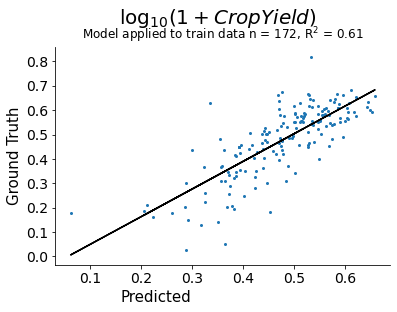

In [28]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [29]:
r2_score(y_train, y_pred)

0.6068220330820603

In [30]:
pearsonr(y_pred, y_train)

(0.7844339775752025, 4.186232741725289e-37)

In [31]:
spearmanr(y_pred, y_train)

SpearmanrResult(correlation=0.7731613457062314, pvalue=1.8865830226084762e-35)

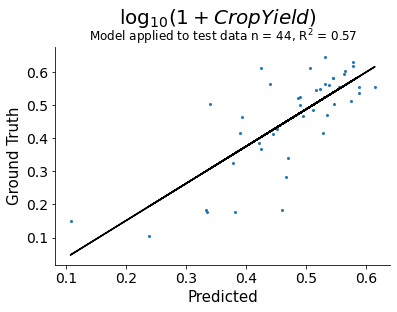

In [32]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [33]:
r2_score(y_test, y_pred)

0.570481842426869

In [34]:
pearsonr(y_pred, y_test)

(0.7670823340169306, 1.2585520942885257e-09)

In [35]:
spearmanr(y_pred, y_test)

SpearmanrResult(correlation=0.7250176180408738, pvalue=2.611794371317887e-08)

In [36]:
pred_features = features.copy()
x_all = pred_features.drop(['year', 'geometry', 'district', 'yield_mt'], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [37]:
plot_features = pred_features[pred_features.year == 2018]
# pred_features

<AxesSubplot:>

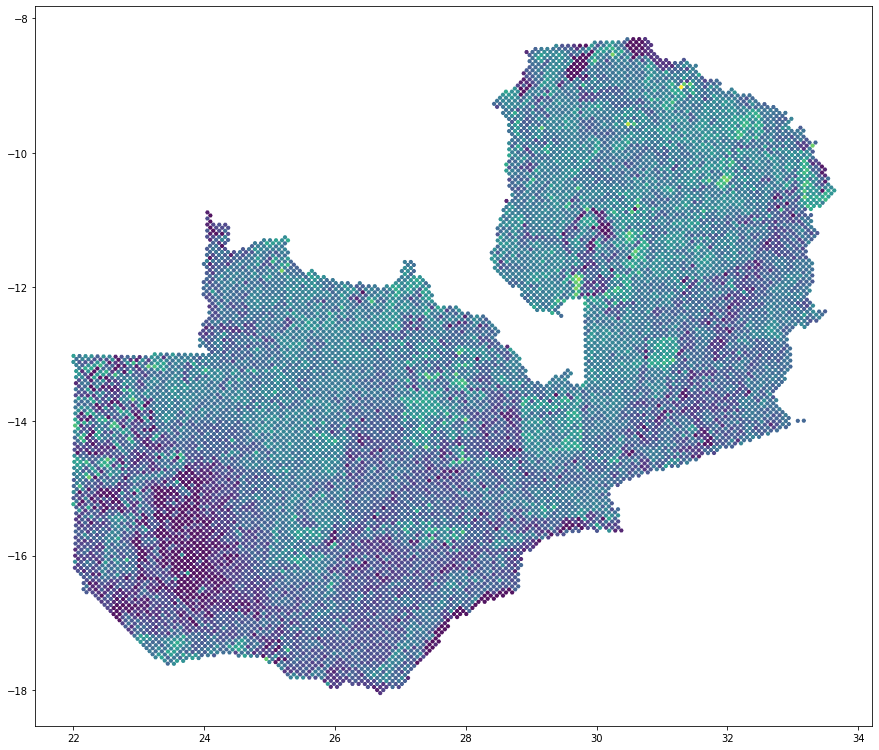

In [38]:
plot_features.plot(figsize = (15,15),
                   marker='H',
                   # legend = True,
                   markersize = 12,
                   alpha = .9,
                   column = 'fit')